In [ ]:
pip install deep_translator

In [ ]:
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


d1_path = 'mendley_data.xlsx'
d2_path = 'kaggle_data.csv'


d1 = pd.read_excel(d1_path, sheet_name='Data', engine='openpyxl')
d2 = pd.read_csv(d2_path)


breed_mapping = {
    'BEN': 'Bengal',
    'SBI': 'Birman',
    'BRI': 'British Shorthair',
    'CHA': 'Chartreux',
    'EUR': 'European',
    'MCO': 'Maine coon',
    'PER': 'Persian',
    'RAG': 'Ragdoll',
    'SPH': 'Savannah',
    'ORI': 'Sphynx',
    'TUV': 'Siamese',
    'Autre': 'Other'
}
age_mapping = {
    'Moinsde1': 0.5,
    '1a2': 1.5,
    '2a10': 6,
    'Plusde10': 11
}

number_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    'Plusde5': 5
}

sex_mapping = {
    'M': 'M',
    'F': 'F'
}

housing_mapping = {
    'ASB': 'ASB',
    'AAB': 'AAB',
    'ML': 'ML',
    'MI': 'MI'
}

zone_mapping = {
    'U': 'U',
    'PU': 'PU',
    'R': 'R'
}

outdoor_time_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

interaction_time_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4
}

abundance_mapping = {
    '1': 1, '2': 2, '3': 3, 'NSP': 0
}

bird_capture_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

mammal_capture_mapping = {
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5
}

default_mapping_values = {
    'Race': 'Other',
    'Number': 1,
    'Age': 1,
    'Sex': 'F',
    'Accommodation': 'ASB',
    'Area': 'U',
    'Ext': 1,
    'Obs': 1,
    'Abundance': 1,
    'PredBird': 1,
    'PredMamm': 1
}

mapping_dict = {
    'Race': breed_mapping,
    'Number': number_mapping,
    'Age': age_mapping,
    'Sex': sex_mapping,
    'Accommodation': housing_mapping,
    'Area': zone_mapping,
    'Ext': outdoor_time_mapping,
    'Obs': interaction_time_mapping,
    'Abundance': abundance_mapping,
    'PredBird': bird_capture_mapping,
    'PredMamm': mammal_capture_mapping
}



translator = GoogleTranslator(source='fr', target='en')
d1.columns = [translator.translate(col) for col in d1.columns]


optional_columns = ["Row.names", "Time stamp", "More"]
d1 = d1.drop(columns=[col for col in optional_columns if col in d1.columns], errors='ignore')



for column, mapping in mapping_dict.items():
    if column in d1.columns:
        d1[column] = d1[column].apply(
            lambda x: mapping.get(x, default_mapping_values[column]) if pd.notnull(x) else np.nan
        )

d1_cleaned = d1.drop_duplicates()
d1_cleaned = d1_cleaned.rename(columns={'Race': 'Breed'})
d2.rename(columns={'name': 'Breed'}, inplace=True)
merged_df = pd.merge(d1_cleaned, d2, on='Breed', how='outer')


print("\nUnique values in Sex column before encoding:")
print(merged_df['Sex'].unique())


categorical_columns = merged_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    merged_df[col] = pd.Categorical(merged_df[col], categories=merged_df[col].dropna().unique(), ordered=False)
    merged_df[col] = merged_df[col].cat.codes.replace(-1, np.nan)


print("\nUnique values in Sex column after encoding:")
print(merged_df['Sex'].unique())


missing_cols = merged_df.columns[merged_df.isna().any()].tolist()
complete_cols = [col for col in merged_df.columns if col not in missing_cols]


def train_model_for_missing_value(column_name):
    train_df = merged_df[merged_df[column_name].notnull()]
    X = train_df.loc[train_df.index, complete_cols]
    y = train_df[column_name]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

    model = RandomForestRegressor(n_estimators=100, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    return model, mse



def augment_dataset(df, column_name, model):
    nan_rows = df[df[column_name].isna()]

    X_nan = df.loc[nan_rows.index, complete_cols]

    if not X_nan.empty:
        predicted_values = model.predict(X_nan)
        df.loc[df[column_name].isna(), column_name] = predicted_values
        print(f"Filled missing values for column: {column_name}")


numeric_missing_cols = [col for col in missing_cols if col in merged_df.columns]
results = {}
augmented_df = merged_df.copy()

for col in numeric_missing_cols:

    model, mse = train_model_for_missing_value(col)
    results[col] = {"model": model, "mse": mse}

    augment_dataset(augmented_df, col, model)


numeric_columns = augmented_df.select_dtypes(include=['float64', 'int64']).columns
augmented_df[numeric_columns] = augmented_df[numeric_columns].round(0).astype(int)


augmented_df.to_csv('augmented_dataset.csv', index=False)
print("Augmented dataset saved as 'augmented_dataset.csv'.")


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

augmented_data_path = 'augmented_dataset.csv'
augmented_df = pd.read_csv(augmented_data_path)


X = augmented_df.drop(columns=['Breed']).values
Y = augmented_df['Breed'].values


X = X / np.max(X, axis=0)


def convert_labels(labels):
    labels = np.array(labels).astype(int)
    classes = np.unique(labels).shape[0]
    matrix = np.zeros((labels.shape[0], classes))
    matrix[np.arange(labels.shape[0]), labels] = 1
    return matrix

Y = convert_labels(Y)



train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=50)


np.random.seed(50)
input_size = train_X.shape[1]
hidden_layer_1 = 150
hidden_layer_2 = 100
classes = train_Y.shape[1]
print(f"Number of unique breeds: {classes}")
dropout_rate = 0.2
reg_lambda = 0.0002

W1 = np.random.randn(input_size, hidden_layer_1) * np.sqrt(2 / input_size)
b1 = np.zeros((1, hidden_layer_1))
W2 = np.random.randn(hidden_layer_1, hidden_layer_2) * np.sqrt(2 / hidden_layer_1)
b2 = np.zeros((1, hidden_layer_2))
W3 = np.random.randn(hidden_layer_2, classes) * np.sqrt(2 / hidden_layer_2)
b3 = np.zeros((1, classes))


def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)


def cross_entropy_loss(y, y_pred):
    eps = 1e-8
    return -np.sum(y * np.log(y_pred + eps)) / y.shape[0]


def gradient_descent(X, y, W1, b1, W2, b2, W3, b3, learning_rate):

    z1 = relu(X @ W1 + b1)
    z1 = apply_dropout(z1, dropout_rate)

    z2 = relu(z1 @ W2 + b2)
    z2 = apply_dropout(z2, dropout_rate)

    y_pred = softmax(z2 @ W3 + b3)


    loss = cross_entropy_loss(y, y_pred)
    loss += reg_lambda * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2)) # sqrt?


    err_output = y_pred - y

    dW3 = z2.T @ err_output / X.shape[0] + reg_lambda * W3
    db3 = np.sum(err_output, axis=0, keepdims=True) / X.shape[0]

    err_hidden_2 = (err_output @ W3.T) * relu_derivative(z2)
    dW2 = z1.T @ err_hidden_2 / X.shape[0] + reg_lambda * W2
    db2 = np.sum(err_hidden_2, axis=0, keepdims=True) / X.shape[0]

    err_hidden_1 = (err_hidden_2 @ W2.T) * relu_derivative(z1)
    dW1 = X.T @ err_hidden_1 / X.shape[0] + reg_lambda * W1
    db1 = np.sum(err_hidden_1, axis=0, keepdims=True) / X.shape[0]

    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    return W1, b1, W2, b2, W3, b3, loss


def update_learning_rate(epoch, current_loss, best_loss, lr, threshold, decay_factor, min_lr, epochs_since_improvement):
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= threshold:
        lr = max(lr * (decay_factor ** epoch), min_lr)
        epochs_since_improvement = 0

    return lr, best_loss, epochs_since_improvement


def apply_dropout(A, rate):
    mask = np.random.binomial(1, 1 - rate, size=A.shape)
    return A * mask / (1 - rate)


def accuracy(X, y, W1, b1, W2, b2, W3, b3):

    z1 = relu(X @ W1 + b1)
    z2 = relu(z1 @ W2 + b2)
    y_pred = softmax(z2 @ W3 + b3)

    predicted_classes = np.argmax(y_pred, axis=1)
    true_classes = np.argmax(y, axis=1)
    return np.mean(predicted_classes == true_classes)


def train_with_scheduler(train_X, train_Y, test_X, test_Y, W1, b1, W2, b2, W3, b3, epochs, batch_size, initial_lr, threshold, decay_factor, min_lr):
    num_batches = np.ceil(train_X.shape[0] / batch_size).astype(int)
    lr = initial_lr
    best_loss = float('inf')
    epochs_since_improvement = 0

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        shuffle_indices = np.random.permutation(train_X.shape[0])
        train_X_shuffled = train_X[shuffle_indices]
        train_Y_shuffled = train_Y[shuffle_indices]

        epoch_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = min(start + batch_size, train_X.shape[0])
            X_batch = train_X_shuffled[start:end]
            y_batch = train_Y_shuffled[start:end]

            W1, b1, W2, b2, W3, b3, batch_loss = gradient_descent(X_batch, y_batch, W1, b1, W2, b2, W3, b3, learning_rate=lr)
            epoch_loss += batch_loss

        epoch_loss /= num_batches

        lr, best_loss, epochs_since_improvement = update_learning_rate(
            epoch, epoch_loss, best_loss, lr, threshold, decay_factor, min_lr, epochs_since_improvement
        )

        train_losses.append(epoch_loss)
        test_loss = cross_entropy_loss(test_Y, softmax(relu(relu(test_X @ W1 + b1) @ W2 + b2) @ W3 + b3))
        test_losses.append(test_loss)

        train_acc = accuracy(train_X, train_Y, W1, b1, W2, b2, W3, b3)
        val_acc = accuracy(test_X, test_Y, W1, b1, W2, b2, W3, b3)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Validation Loss: {test_loss:.4f}, Learning Rate: {lr:.6f}")
        print(f"Training Accuracy: {train_acc * 100:.2f}%, Validation Accuracy: {val_acc * 100:.2f}%\n")

    return W1, b1, W2, b2, W3, b3, train_losses, test_losses


W1, b1, W2, b2, W3, b3, train_losses, test_losses = train_with_scheduler(
    train_X, train_Y, test_X, test_Y,
    W1, b1, W2, b2, W3, b3,
    epochs=100, batch_size=100, initial_lr=0.2, threshold=3, decay_factor=0.2, min_lr=0.01
)


test_accuracy = accuracy(test_X, test_Y, W1, b1, W2, b2, W3, b3)
print(f"Testing Data Accuracy: {test_accuracy * 100:.2f}%")



Number of unique breeds: 76
Epoch 1/100, Loss: 2.8765, Validation Loss: 2.0772, Learning Rate: 0.200000
Training Accuracy: 33.79%, Validation Accuracy: 32.14%

Epoch 2/100, Loss: 2.2422, Validation Loss: 2.3317, Learning Rate: 0.200000
Training Accuracy: 30.31%, Validation Accuracy: 28.71%

Epoch 3/100, Loss: 2.0657, Validation Loss: 1.8658, Learning Rate: 0.200000
Training Accuracy: 44.14%, Validation Accuracy: 42.28%

Epoch 4/100, Loss: 1.8280, Validation Loss: 1.2479, Learning Rate: 0.200000
Training Accuracy: 71.17%, Validation Accuracy: 70.51%

Epoch 5/100, Loss: 1.6307, Validation Loss: 1.3125, Learning Rate: 0.200000
Training Accuracy: 73.91%, Validation Accuracy: 72.07%

Epoch 6/100, Loss: 1.5894, Validation Loss: 1.0513, Learning Rate: 0.200000
Training Accuracy: 75.08%, Validation Accuracy: 74.10%

Epoch 7/100, Loss: 1.4156, Validation Loss: 0.8902, Learning Rate: 0.200000
Training Accuracy: 83.24%, Validation Accuracy: 81.28%

Epoch 8/100, Loss: 1.2593, Validation Loss: 0.87

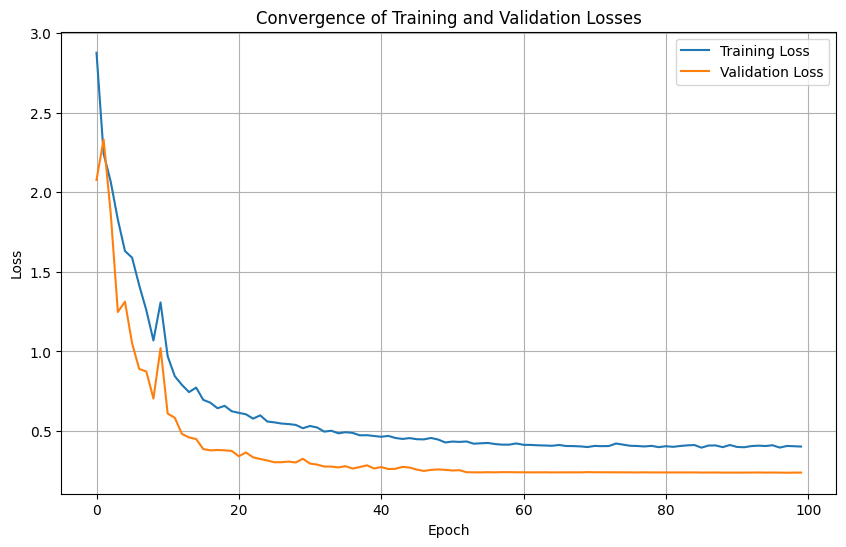

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Convergence of Training and Validation Losses")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# predictions = np.argmax(softmax(relu(relu(test_X @ W1 + b1) @ W2 + b2) @ W3 + b3), axis=1)
# true_labels = np.argmax(test_Y, axis=1)
# misclassified = predictions != true_labels

# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 8))
# plt.scatter(test_X[~misclassified][:, 0], test_X[~misclassified][:, 1], label="Correctly Classified", alpha=0.7)
# plt.scatter(test_X[misclassified][:, 0], test_X[misclassified][:, 1], label="Misclassified", color="red", alpha=0.7)
# plt.axhline(0, color="black", linewidth=0.5)
# plt.axvline(0, color="black", linewidth=0.5)
# plt.xlabel("Feature 1")
# plt.ylabel("Feature 2")
# plt.title("Misclassified Points")
# plt.legend()
# plt.grid()
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

predictions = np.argmax(softmax(relu(relu(test_X @ W1 + b1) @ W2 + b2) @ W3 + b3), axis=1)
true_labels = np.argmax(test_Y, axis=1)
misclassified = predictions != true_labels

try:
    misclassified_indices = np.where(misclassified)[0]
    misclassified_data = test_X[misclassified_indices]
    misclassified_pred_labels = predictions[misclassified_indices]
    misclassified_true_labels = true_labels[misclassified_indices]

    misclassified_pred_breeds = [label_to_breed[label] for label in misclassified_pred_labels]
    misclassified_true_breeds = [label_to_breed[label] for label in misclassified_true_labels]


    plt.figure(figsize=(15, 10))
    plt.scatter(
        range(len(misclassified_indices)),
        misclassified_pred_breeds,
        label="Predicted Labels",
        alpha=0.7,
        marker='o'
    )
    plt.scatter(
        range(len(misclassified_indices)),
        misclassified_true_breeds,
        label="True Labels",
        alpha=0.7,
        marker='x'
    )
    plt.xlabel("Misclassified Instance Index")
    plt.ylabel("Breed Label")
    plt.title("Visualization of Misclassified Breeds")
    plt.legend()
    plt.grid()
    plt.show()

except NameError as e:
    print("Error: Missing variables or definitions in the context. Ensure earlier steps have been executed.")
    print(e)
